In [19]:
import cv2
import os
import re
import matplotlib.pyplot as plt
import ants
import skimage
from tqdm import tqdm
from joblib import Parallel, delayed

# import cucim

In [20]:
img_dir = '/storage/valis_reg/BFIW_original/'
imgs = os.listdir(img_dir)
regex = re.compile(r".*-SE_(\d+)_original.jpg")
imgs = sorted(imgs, key=lambda x: int(regex.match(x).group(1)))
imgs_ordered = {}
for img in imgs:
    section_num = int(regex.match(img).group(1))
    section_id = str(section_num)
    section_id_digits = len(section_id)
    if section_id_digits <4:
        section_id = '0'*(4-section_id_digits) + str(section_num)
    imgs_ordered[section_id] = os.path.join(img_dir, img)

In [21]:
import numpy as np
import cv2

def get_ksize(sigma):
    # opencv calculates ksize from sigma as
    # sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
    # then ksize from sigma is
    # ksize = ((sigma - 0.8)/0.15) + 2.0

    return int(((sigma - 0.8)/0.15) + 2.0)

def get_gaussian_blur(img, ksize=0, sigma=5):
    # if ksize == 0, then compute ksize from sigma
    if ksize == 0:
        ksize = get_ksize(sigma)

    # Gaussian 2D-kernel can be seperable into 2-orthogonal vectors
    # then compute full kernel by taking outer product or simply mul(V, V.T)
    sep_k = cv2.getGaussianKernel(ksize, sigma)

    # if ksize >= 11, then convolution is computed by applying fourier transform
    return cv2.filter2D(img, -1, np.outer(sep_k, sep_k))

def ssr(img, sigma):
    # Single-scale retinex of an image
    # SSR(x, y) = log(I(x, y)) - log(I(x, y)*F(x, y))
    # F = surrounding function, here Gaussian

    return np.log10(img) - np.log10(get_gaussian_blur(img, ksize=0, sigma=sigma) + 1.0)

def msr(img, sigma_scales=[15, 80, 250]):
    # Multi-scale retinex of an image
    # MSR(x,y) = sum(weight[i]*SSR(x,y, scale[i])), i = {1..n} scales

    msr = np.zeros(img.shape)
    # for each sigma scale compute SSR
    for sigma in sigma_scales:
        msr += ssr(img, sigma)

    # divide MSR by weights of each scale
    # here we use equal weights
    msr = msr / len(sigma_scales)

    # computed MSR could be in range [-k, +l], k and l could be any real value
    # so normalize the MSR image values in range [0, 255]
    msr = cv2.normalize(msr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)

    return msr

def color_balance(img, low_per, high_per):
    '''Contrast stretch img by histogram equilization with black and white cap'''

    tot_pix = img.shape[1] * img.shape[0]
    # no.of pixels to black-out and white-out
    low_count = tot_pix * low_per / 100
    high_count = tot_pix * (100 - high_per) / 100

    # channels of image
    ch_list = []
    if len(img.shape) == 2:
        ch_list = [img]
    else:
        ch_list = cv2.split(img)

    cs_img = []
    # for each channel, apply contrast-stretch
    for i in range(len(ch_list)):
        ch = ch_list[i]
        # cummulative histogram sum of channel
        cum_hist_sum = np.cumsum(cv2.calcHist([ch], [0], None, [256], (0, 256)))

        # find indices for blacking and whiting out pixels
        li, hi = np.searchsorted(cum_hist_sum, (low_count, high_count))
        if (li == hi):
            cs_img.append(ch)
            continue
        # lut with min-max normalization for [0-255] bins
        lut = np.array([0 if i < li
                        else (255 if i > hi else round((i - li) / (hi - li) * 255))
                        for i in np.arange(0, 256)], dtype = 'uint8')
        # constrast-stretch channel
        cs_ch = cv2.LUT(ch, lut)
        cs_img.append(cs_ch)

    if len(cs_img) == 1:
        return np.squeeze(cs_img)
    elif len(cs_img) > 1:
        return cv2.merge(cs_img)
    return None

def msrcr(img, sigma_scales=[15, 80, 250], alpha=125, beta=46, G=192, b=-30, low_per=1, high_per=3):
    # Multi-scale retinex with Color Restoration
    # MSRCR(x,y) = G * [MSR(x,y)*CRF(x,y) - b], G=gain and b=offset
    # CRF(x,y) = beta*[log(alpha*I(x,y) - log(I'(x,y))]
    # I'(x,y) = sum(Ic(x,y)), c={0...k-1}, k=no.of channels

    img = img.astype(np.float64) + 1.0
    # Multi-scale retinex and don't normalize the output
    msr_img = msr(img, sigma_scales)
    # Color-restoration function
    crf = beta * (np.log10(alpha * img) - np.log10(np.sum(img, axis=2, keepdims=True)))
    # MSRCR
    msrcr_ = G * (msr_img*crf - b)
    # normalize MSRCR
    msrcr_ = cv2.normalize(msrcr_, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3) # type: ignore
    # color balance the final MSRCR to flat the histogram distribution with tails on both sides
    msrcr_ = color_balance(msrcr_, low_per, high_per)

    return msrcr_

(-0.5, 1547.5, 1535.5, -0.5)

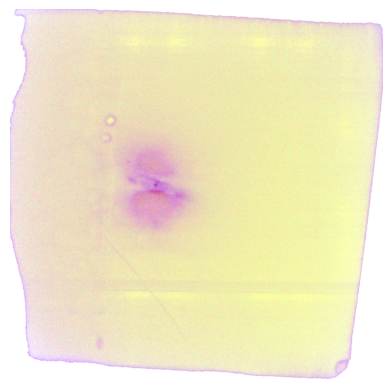

In [137]:
# ssr_img = ssr(np.min(img, -1), 5)
import numpy as np
import scipy
import skimage
img_path = img_dir + imgs[0]
# img_path = '/storage/valis_reg/cropped_imgs/1806.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ssr_img = msrcr(img.copy())
ssr_img_gray = cv2.cvtColor(ssr_img.copy(), cv2.COLOR_RGB2GRAY)  # type: ignore
# img = np.min(img.clip(100,150),0)
# return img
# sample_img = read_image_gray(img_dir + imgs[1606])
sample_ants = ants.from_numpy(ssr_img_gray)
sample_mask = sample_ants.get_mask(cleanup=4) # type: ignore
mask = sample_mask.numpy().astype(np.uint8)
blank_white = (np.ones_like(ssr_img) * 255).astype(np.uint8)
# for i in range(3):
#     blank_white[mask==1] = img[mask==1]
for i in range(3):
    blank_white[:,:,i][mask==1] = ssr_img[:,:,i][mask==1] # type: ignore
# plt.imshow(blank_white)
# jet 
# plt.imshow(cv2.cvtColor(blank_white, cv2.COLOR_RGB2GRAY), cmap='jet')
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
# find the bounding box of the largest contour
x, y, w, h = cv2.boundingRect(contours[0])
# draw the bounding box
# blnk_rect = cv2.rectangle(blank_white, (x, y), (x+w, y+h), (0, 255, 0), 2)
rect_blank = blank_white.copy()[y:y+h, x:x+w]
rect_mask = mask.copy()[y:y+h, x:x+w]
# blank_rect = np.ones_like(rect_mask) * 255
plt.imshow(rect_blank[:,:,1])
alpha = 1.1
xy = (
    (rect_blank[:, :, 2] < alpha*skimage.filters.threshold_otsu(rect_blank[:, :, 2])).astype(
        np.uint8
    )
    + (
        rect_blank[:, :, 1] < alpha*skimage.filters.threshold_otsu(rect_blank[:, :, 1])
    ).astype(np.uint8)
    + (
        rect_blank[:, :, 0] < alpha*skimage.filters.threshold_otsu(rect_blank[:, :, 0])
    ).astype(np.uint8)
)
blurred_xy = cv2.GaussianBlur((xy==3).astype(np.uint8).copy(), (13, 13), 0)
blurred_xy = cv2.GaussianBlur(blurred_xy.copy(), (9, 9), 0)
blurred_xy = cv2.medianBlur(blurred_xy, 9)
# dilate the mask
blurred_xy = cv2.dilate(blurred_xy, (9,9), iterations=10) # type: ignore
# Rectangle Crop
contours,_ = cv2.findContours(blurred_xy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
bbox = cv2.boundingRect(contours[0])
x, y, w, h = bbox
rect_blank = rect_blank[int(0.9*y):y+h+int(y*0.1), int(0.9*x):x+w+int(x*0.1)]
plt.imshow(rect_blank)
plt.axis('off')


In [24]:
imgs[814]

'B_213-ST_BFIW-SE_841_original.jpg'

In [30]:
img_path = img_dir + 'B_213-ST_BFIW-SE_1606_original.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ssr_img = msrcr(img.copy())
ssr_img_gray = cv2.cvtColor(ssr_img.copy(), cv2.COLOR_RGB2GRAY)  # type: ignore
sample_ants = ants.from_numpy(ssr_img_gray)
sample_mask = sample_ants.get_mask(cleanup=4) # type: ignore
mask = sample_mask.numpy().astype(np.uint8)
blank_white = (np.ones_like(ssr_img) * 255).astype(np.uint8)
# for i in range(3):
#     blank_white[mask==1] = img[mask==1]
for i in range(3):
    blank_white[:,:,i][mask==1] = ssr_img[:,:,i][mask==1] # type: ignore

# plt.imshow(blank_white)
master_mask = mask.copy()

In [34]:
imgs_ordered

{'0002': '/storage/valis_reg/BFIW_original/B_213-ST_BFIW-SE_2_original.jpg',
 '0003': '/storage/valis_reg/BFIW_original/B_213-ST_BFIW-SE_3_original.jpg',
 '0004': '/storage/valis_reg/BFIW_original/B_213-ST_BFIW-SE_4_original.jpg',
 '0005': '/storage/valis_reg/BFIW_original/B_213-ST_BFIW-SE_5_original.jpg',
 '0006': '/storage/valis_reg/BFIW_original/B_213-ST_BFIW-SE_6_original.jpg',
 '0007': '/storage/valis_reg/BFIW_original/B_213-ST_BFIW-SE_7_original.jpg',
 '0008': '/storage/valis_reg/BFIW_original/B_213-ST_BFIW-SE_8_original.jpg',
 '0009': '/storage/valis_reg/BFIW_original/B_213-ST_BFIW-SE_9_original.jpg',
 '0010': '/storage/valis_reg/BFIW_original/B_213-ST_BFIW-SE_10_original.jpg',
 '0011': '/storage/valis_reg/BFIW_original/B_213-ST_BFIW-SE_11_original.jpg',
 '0012': '/storage/valis_reg/BFIW_original/B_213-ST_BFIW-SE_12_original.jpg',
 '0013': '/storage/valis_reg/BFIW_original/B_213-ST_BFIW-SE_13_original.jpg',
 '0014': '/storage/valis_reg/BFIW_original/B_213-ST_BFIW-SE_14_original.

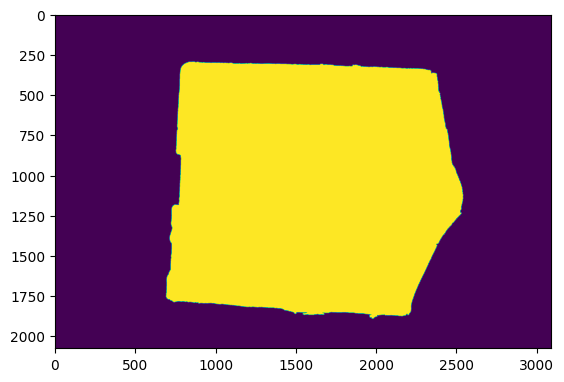

In [31]:
plt.imshow(master_mask)

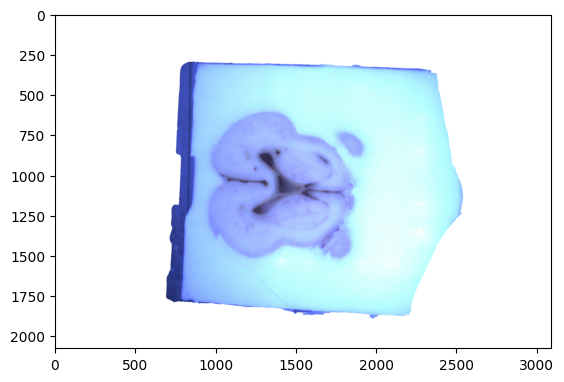

In [33]:
img_path = img_dir + 'B_213-ST_BFIW-SE_814_original.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ref_masked_img = (np.ones_like(img) * 255).astype(np.uint8)
for i in range(3):
    ref_masked_img[:,:,i][master_mask==1] = img[:,:,i][master_mask==1] # type: ignore
plt.imshow(ref_masked_img)

In [ ]:

ssr_img = msrcr(img.copy())
ssr_img_gray = cv2.cvtColor(ssr_img.copy(), cv2.COLOR_RGB2GRAY)  # type: ignore
sample_ants = ants.from_numpy(ssr_img_gray)
sample_mask = sample_ants.get_mask(cleanup=4) # type: ignore
mask = sample_mask.numpy().astype(np.uint8)
blank_white = (np.ones_like(ssr_img) * 255).astype(np.uint8)
# for i in range(3):
#     blank_white[mask==1] = img[mask==1]
for i in range(3):
    blank_white[:,:,i][mask==1] = ssr_img[:,:,i][mask==1] # type: ignore

# plt.imshow(blank_white)
master_mask = mask.copy()

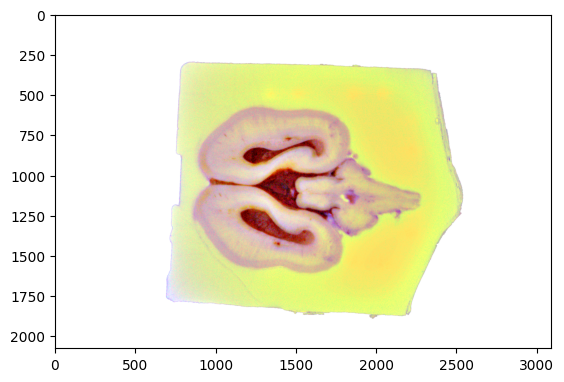

In [27]:
sample_ants = ants.from_numpy(ssr_img_gray)
sample_mask = sample_ants.get_mask(cleanup=4) # type: ignore
mask = sample_mask.numpy().astype(np.uint8)
blank_white = (np.ones_like(ssr_img) * 255).astype(np.uint8)
# for i in range(3):
#     blank_white[mask==1] = img[mask==1]
for i in range(3):
    blank_white[:,:,i][mask==1] = ssr_img[:,:,i][mask==1] # type: ignore

plt.imshow(blank_white)

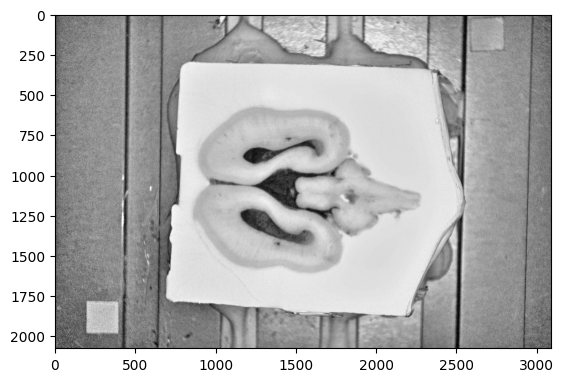

In [26]:
plt.imshow(ssr_img_gray, cmap='gray')

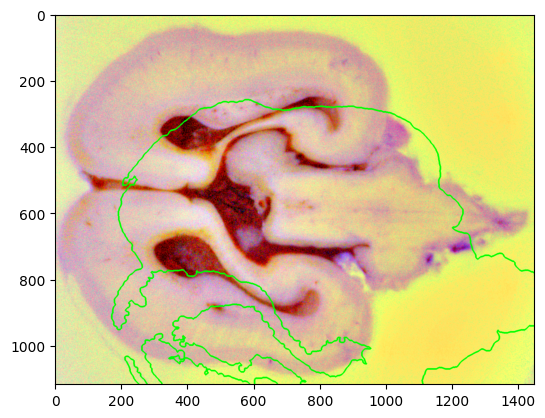

In [128]:

# Draw the contour
plt.imshow(cv2.drawContours(rect_blank.copy(), contours, 0, (0, 255, 0), 3))

In [59]:
skimage.filters.threshold_otsu(rect_blank[:,:,2])

201

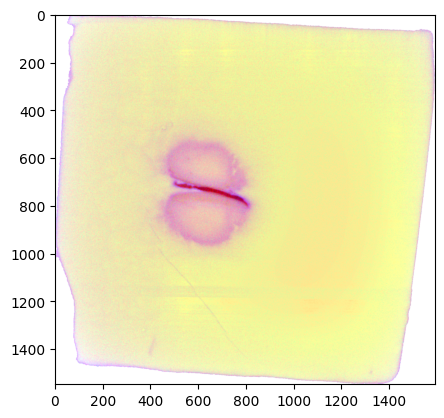

In [13]:
import cv2

img = cv2.imread('/storage/valis_reg/BFIW_Block/msrcr/0052.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [17]:
seg = skimage.segmentation.felzenszwalb(img, scale=500, min_size=500)

In [1]:
import cv2
import os
import re
import matplotlib.pyplot as plt
import ants
import valis
from valis import registration, feature_detectors, non_rigid_registrars, affine_optimizer



/usr/local/src/.venv/lib/python3.12/site-packages/SimpleITK/extra.py:457: SyntaxWarning: invalid escape sequence '\s'
  """Blurs an image by separable convolution with discrete
/usr/local/src/valis/valtils.py:92: SyntaxWarning: invalid escape sequence '\.'
  if re.search("\.", f) is None:


In [2]:
def sort_files_by_digit(directory):
    """Sorts files in a directory based on the digit before "_processed.jpg".

    Args:
        directory: The directory path containing the files.
    """

    files = os.listdir(directory)
    file_info = []

    for file in files[:-30]:
        if file.endswith("_processed.jpg"):
            digit = file.split("_")[3]
            try:
                digit = int(digit)
                file_info.append((digit, file))
            except ValueError:
                # Handle files without a digit prefix
                pass

    # Sort the files based on the digit
    sorted_files = sorted(file_info, key=lambda x: x[0])

    # Extract the original file names from the sorted tuples
    sorted_file_names = [file[1] for file in sorted_files]

    return sorted_file_names

In [8]:
from valis import registration
from natsort import natsorted 
#img_dir = './cropped_imgs_new/'
img_dir ='/storage/valis_reg/test_block_out/msrcr'
#imgs = os.listdir(img_dir)
#regex = re.compile(r".*.jpg")
imgs = sort_files_by_digit(img_dir)
slide_src_dir = img_dir
results_dst_dir = '/storage/valis_reg/msrcr_reg'
registered_slide_dst_dir = '/storage/valis_reg/msrcr_reg_slides'
os.makedirs(results_dst_dir, exist_ok=True)
os.makedirs(registered_slide_dst_dir, exist_ok=True)
reference_slide = "/storage/valis_reg/test_block_out/msrcr/1606_msrcr.jpg"
registrar = registration.Valis(slide_src_dir, results_dst_dir, reference_img_f=reference_slide)
registrar.imgs_ordered=True
registrar.crop='overlap'
registrar.align_to_reference = True
# registrar.non_rigid_registrar_cls = non_rigid_registrars.SimpleElastixWarper
rigid_registrar, non_rigid_registrar, error_df = registrar.register()



==== Converting images



Converting images:   0%|          | 0/63 [00:00<?, ?image/s]

<Slide, name = 0008_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a00b0> True (688, 1024, 3)
<Slide, name = 0060_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfba141f40> True (688, 1024, 3)


Converting images:   3%|▎         | 2/63 [00:00<00:03, 15.83image/s]

<Slide, name = 0145_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a1400> True (688, 1024, 3)
<Slide, name = 0220_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a29f0> True (688, 1024, 3)


Converting images:   6%|▋         | 4/63 [00:00<00:03, 17.14image/s]

<Slide, name = 0244_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a2000> True (688, 1024, 3)
<Slide, name = 0254_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a1fa0> True (688, 1024, 3)


Converting images:  10%|▉         | 6/63 [00:00<00:03, 17.09image/s]

<Slide, name = 0282_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a0bc0> True (688, 1024, 3)
<Slide, name = 0356_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a3f80> True (688, 1024, 3)


Converting images:  13%|█▎        | 8/63 [00:00<00:03, 17.49image/s]

<Slide, name = 0412_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a1dc0> True (688, 1024, 3)
<Slide, name = 0498_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a24b0> True (688, 1024, 3)


Converting images:  16%|█▌        | 10/63 [00:00<00:03, 17.53image/s]

<Slide, name = 0507_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a3ef0> True (688, 1024, 3)
<Slide, name = 0659_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a0410> True (688, 1024, 3)


Converting images:  19%|█▉        | 12/63 [00:00<00:02, 17.58image/s]

<Slide, name = 0711_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a3020> True (688, 1024, 3)
<Slide, name = 0721_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a0b30> True (688, 1024, 3)


Converting images:  22%|██▏       | 14/63 [00:00<00:02, 17.48image/s]

<Slide, name = 0834_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a1190> True (688, 1024, 3)
<Slide, name = 0846_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a14c0> True (688, 1024, 3)


Converting images:  25%|██▌       | 16/63 [00:00<00:02, 17.51image/s]

<Slide, name = 0894_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a3fb0> True (688, 1024, 3)
<Slide, name = 0917_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a3440> True (688, 1024, 3)


Converting images:  29%|██▊       | 18/63 [00:01<00:02, 17.21image/s]

<Slide, name = 0994_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a3c20> True (688, 1024, 3)
<Slide, name = 1045_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a2690> True (688, 1024, 3)


Converting images:  32%|███▏      | 20/63 [00:01<00:02, 17.03image/s]

<Slide, name = 1080_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a0890> True (688, 1024, 3)
<Slide, name = 1086_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a0e90> True (688, 1024, 3)


Converting images:  35%|███▍      | 22/63 [00:01<00:02, 16.88image/s]

<Slide, name = 1150_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a2810> True (688, 1024, 3)
<Slide, name = 1177_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a0050> True (688, 1024, 3)


Converting images:  38%|███▊      | 24/63 [00:01<00:02, 16.94image/s]

<Slide, name = 1187_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82bb410> True (688, 1024, 3)
<Slide, name = 1211_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a23f0> True (688, 1024, 3)


Converting images:  41%|████▏     | 26/63 [00:01<00:02, 17.06image/s]

<Slide, name = 1212_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a0c80> True (688, 1024, 3)
<Slide, name = 1222_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a19d0> True (688, 1024, 3)


Converting images:  44%|████▍     | 28/63 [00:01<00:02, 16.97image/s]

<Slide, name = 1237_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a2240> True (688, 1024, 3)
<Slide, name = 1260_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a30e0> True (688, 1024, 3)


Converting images:  48%|████▊     | 30/63 [00:01<00:01, 16.97image/s]

<Slide, name = 1360_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a0cb0> True (688, 1024, 3)
<Slide, name = 1404_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a02c0> True (688, 1024, 3)


Converting images:  51%|█████     | 32/63 [00:01<00:01, 17.06image/s]

<Slide, name = 1426_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a0380> True (688, 1024, 3)
<Slide, name = 1435_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a08c0> True (688, 1024, 3)


Converting images:  54%|█████▍    | 34/63 [00:01<00:01, 16.84image/s]

<Slide, name = 1457_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a06b0> True (688, 1024, 3)
<Slide, name = 1555_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a1370> True (688, 1024, 3)


Converting images:  57%|█████▋    | 36/63 [00:02<00:01, 17.37image/s]

<Slide, name = 1566_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a3620> True (688, 1024, 3)
<Slide, name = 1588_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a2450> True (688, 1024, 3)


Converting images:  60%|██████    | 38/63 [00:02<00:01, 17.50image/s]

<Slide, name = 1599_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a2c90> True (688, 1024, 3)
<Slide, name = 1606_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a16a0> True (688, 1024, 3)


Converting images:  63%|██████▎   | 40/63 [00:02<00:01, 17.57image/s]

<Slide, name = 1610_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a3890> True (688, 1024, 3)
<Slide, name = 1620_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a35f0> True (688, 1024, 3)


Converting images:  67%|██████▋   | 42/63 [00:02<00:01, 17.48image/s]

<Slide, name = 1681_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa8298bf0> True (688, 1024, 3)
<Slide, name = 1718_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a3ec0> True (688, 1024, 3)


Converting images:  70%|██████▉   | 44/63 [00:02<00:01, 17.49image/s]

<Slide, name = 1745_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82999a0> True (688, 1024, 3)
<Slide, name = 1801_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a3260> True (688, 1024, 3)


Converting images:  73%|███████▎  | 46/63 [00:02<00:00, 17.48image/s]

<Slide, name = 1803_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa81fdc40> True (688, 1024, 3)
<Slide, name = 1835_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa829a960> True (688, 1024, 3)


Converting images:  76%|███████▌  | 48/63 [00:02<00:00, 17.56image/s]

<Slide, name = 1883_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa8263260> True (688, 1024, 3)
<Slide, name = 1947_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a2780> True (688, 1024, 3)


Converting images:  79%|███████▉  | 50/63 [00:02<00:00, 17.33image/s]

<Slide, name = 2086_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa8261460> True (688, 1024, 3)
<Slide, name = 2088_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a8410> True (688, 1024, 3)


Converting images:  83%|████████▎ | 52/63 [00:03<00:00, 17.34image/s]

<Slide, name = 2144_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a1b80> True (688, 1024, 3)
<Slide, name = 2154_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a8e90> True (688, 1024, 3)


Converting images:  86%|████████▌ | 54/63 [00:03<00:00, 17.13image/s]

<Slide, name = 2231_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a9e80> True (688, 1024, 3)
<Slide, name = 2260_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a8d40> True (688, 1024, 3)


Converting images:  89%|████████▉ | 56/63 [00:03<00:00, 16.83image/s]

<Slide, name = 2261_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82ab020> True (688, 1024, 3)
<Slide, name = 2281_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82aa8d0> True (688, 1024, 3)


Converting images:  92%|█████████▏| 58/63 [00:03<00:00, 17.28image/s]

<Slide, name = 2301_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa8260c20> True (688, 1024, 3)
<Slide, name = 2306_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82aa930> True (688, 1024, 3)


Converting images:  95%|█████████▌| 60/63 [00:03<00:00, 17.41image/s]

<Slide, name = 2343_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82a10d0> True (688, 1024, 3)
<Slide, name = 2359_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82aafc0> True (688, 1024, 3)


Converting images:  98%|█████████▊| 62/63 [00:03<00:00, 17.32image/s]

<Slide, name = 2589_msrcr>, width=3088, height=2076, channels=3, levels=1, RGB=True, dtype=uint8> <valis.slide_io.VipsSlideReader object at 0x7fdfa82ab4d0> True (688, 1024, 3)


Converting images: 100%|██████████| 63/63 [00:03<00:00, 17.27image/s]



==== Processing images



Normalizing images: 100%|██████████| 63/63 [00:04<00:00, 13.97image/s]



==== Rigid registration



Detecting features   : 100%|██████████| 63/63 [00:28<00:00,  2.20image/s]


QUEUEING TASKS | Matching images      :   0%|          | 0/63 [00:00<?, ?image/s]

PROCESSING TASKS | Matching images      :   0%|          | 0/63 [00:00<?, ?image/s]

COLLECTING RESULTS | Matching images      :   0%|          | 0/63 [00:00<?, ?image/s]

Finalizing           : 100%|██████████| 63/63 [00:00<00:00, 10217.35image/s]



======== Rigid registration complete in 2.954 minutes


==== Non-rigid registration

Creating non-rigid mask


Finding non-rigid transforms:  62%|██████▏   | 39/63 [03:43<02:17,  5.74s/image]


KeyboardInterrupt: 